In [15]:
######################################################################
######################################################################
###### WRITTEN BY NEHA HUNKA, NHUNKA@UMD.EDU #########################
######################################################################
######################################################################

# This notebook shows how to integrate Sudan NFI-estimated AGBD and Volume, 
# Forest probability map and GEDI Forest biomass estimates (see https://glad.umd.edu/dataset/gedi). 
# It relies on the computational power of the INLA Package in R (https://www.r-inla.org/).  

################################# ################################# #############################
################################# Geostatistical Model-based Estimation #########################
################################# ################################# #############################

# Our target variable (AGBD) at any given location (s) is assumed to follow the following linear model
# 
# \begin{align}
# y(s) = (\alpha + \tilde{\alpha}(s)) + (\beta + \tilde{\beta}(s)).x1(s) + (\eta + \tilde{\eta}(s)).x2(s) + \epsilon(s) 
# \end{align}
# 
# Most of the values should be familiar. $\alpha$, $\beta$ and $\eta$ are constant regression parameters. 
# x1 and x2 are our covariates (here, the FNF probability map and the GEDI-based height map). 
# $\alpha$, $\beta$ and $\eta$ have associated errors $\tilde{\alpha}$, $\tilde{\beta}$ and $\tilde{\eta}$ 
#   that are spatially autocorrelated. These errors capture the spatially-varying component of 
# $\alpha$, $\beta$ and $\eta$. In a Bayesian hierarchical framework, it is possible to estimate 
# the spatial covariance parameters and, hence, propagate their uncertainties through to the 
# prediction of the outcome variable (Babcock et al. 2015). 
# 
# A caveat, however, is that solving the above model is natively is computationally expensive when 
# the number of observations becomes large. We can circumvent this by splitting Sudan up into 
# (very) small regions. This is done by the use of a mesh, and approximating the model outputs 
# for each node/vertex of the mesh. First, define an underlying "mesh", which draws a graph of 
# triangles across the study area. On the vertices of triangles, we define a neighbor-based 
# spatial model where two vertices are neighbors if there is a triangle edge connecting them.
# To extend this to continuous locations, the value of $\tilde{\alpha}$, $\tilde{\beta}$ and 
# $\tilde{\eta}$ at any location (s) lying within a triangle is linearly interpolated from the 
# 3 vertices of the containing triangle. The reason why this is more computationally efficient 
# is that the process on the vertices is sparse, i.e. for any given vertex, it only needs the 
# information from the connected vertices. This will become clearer as we go through the code. 

############# AT THE START, WE INSTALL PACKAGES WE NEED ###############

# We use a package that might be new to some of you, called "INLA" 
# This package helps implement Bayesian methods and helps make some of our steps fast/easy to implement

############# OPEN R, THEN RUN THE FOLLOWING COMMAND ###################

# install.packages("INLA",repos=c(getOption("repos"),INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)
# install.packages("fmesher", dependencies = TRUE)
# install.packages("MatrixModels", type = "source")
# install.packages("exactextractr")
# install.packages("inlabru")
# install.packages("sn" ,dependencies = TRUE)
# packages <- c("terra","dplyr","spdep", "exactextractr", "sf","ggplot2","viridis","sn","fmesher","exactextractr","fields")
# package.check <- lapply(packages, FUN = function(x) {
#   if (!require(x, character.only = TRUE)) {
#     install.packages(x, dependencies = TRUE)
#     library(x, character.only = TRUE, quietly=TRUE)
#   }
# })
# Sys.setenv("AWS_DEFAULT_REGION" = 'us-west-2')

######################################################
############## LOAD PACKAGES #########################
######################################################

library("fmesher")
library(MatrixModels)
library(Matrix)
library(INLA)
library(inlabru)
library("jpeg")
library(gstat)

library(sf)
library(terra)
library(dplyr)
library(spdep)
library(raster)
# library(exactextractr)

library(ggplot2)
library(viridis)
library(stringr)
# library(sn)

# setwd("/home/sepal-user/Sudan_2025_FRL")

In [ ]:
#################################################################
# ##### EXTRACT COVARIATE VALUES AT NFI PLOTS ###################
#################################################################

# NFI <- st_read("Sudan_NFI_Volume.gpkg") %>% st_transform("epsg:6933")
# DATA = NFI %>% st_drop_geometry()

# GEDI_L4A <- rast("GEDI_L4A_AGB_Sudan_6933.tif")
# GEDI_L4A.plot = exactextractr::exact_extract(GEDI_L4A,st_buffer(NFI,250), 'mean')
# DATA$gedi.agbd <- GEDI_L4A.plot

# FNF <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Sudan_FNF_probability_2023_updated_6933.tif") 
# FNF.plot = exactextractr::exact_extract(FNF,st_buffer(NFI,250), 'mean')
# DATA$FNF.prob <- FNF.plot
# ##### write.csv(DATA,"DATA.csv",row.names=FALSE)

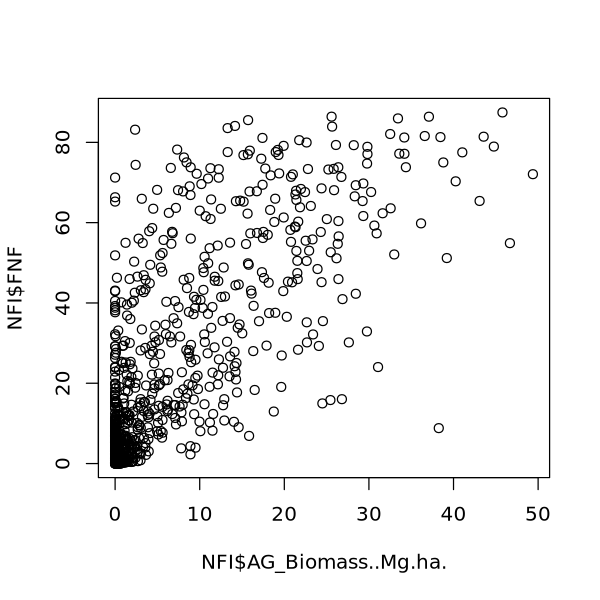


Call:
lm(formula = NFI$AG_Biomass..Mg.ha. ~ NFI$GEDI_L4A)

Residuals:
    Min      1Q  Median      3Q     Max 
-36.511  -2.607  -1.707   1.605  32.089 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.15145    0.30364   3.792 0.000161 ***
NFI$GEDI_L4A  0.97396    0.03176  30.667  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.532 on 781 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.5463,	Adjusted R-squared:  0.5457 
F-statistic: 940.5 on 1 and 781 DF,  p-value: < 2.2e-16


Warning message in NFI$AG_Biomass..Mg.ha. - predictions:
“longer object length is not a multiple of shorter object length”


[1] "RMSE: 7.59738951270061"


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


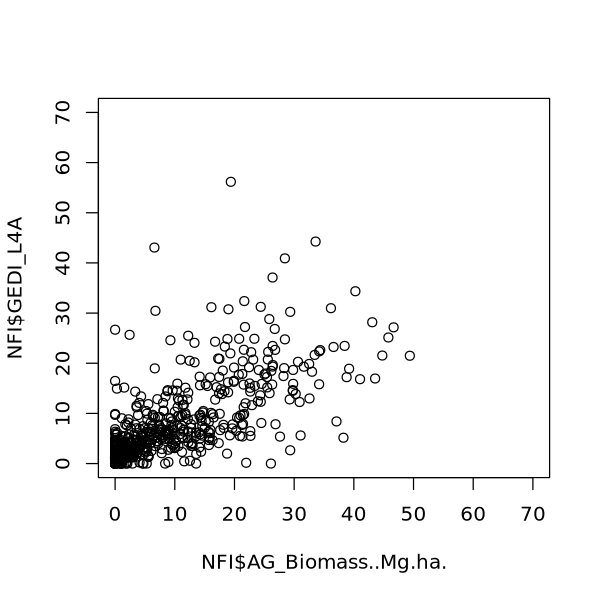

Time used:
    Pre = 0.24, Running = 0.301, Post = 0.0877, Total = 0.629 
Fixed effects:
             mean    sd 0.025quant 0.5quant 0.975quant  mode kld
(Intercept) 1.149 0.303      0.555    1.149      1.743 1.149   0
GEDI_L4A    0.974 0.032      0.912    0.974      1.036 0.974   0

Model hyperparameters:
                                         mean    sd 0.025quant 0.5quant
Precision for the Gaussian observations 0.024 0.001      0.021    0.024
                                        0.975quant  mode
Precision for the Gaussian observations      0.026 0.023

Deviance Information Criterion (DIC) ...............: 5170.49
Deviance Information Criterion (DIC, saturated) ....: 789.31
Effective number of parameters .....................: 2.99

Watanabe-Akaike information criterion (WAIC) ...: 5177.90
Effective number of parameters .................: 10.04

Marginal log-Likelihood:  -2605.42 
CPO, PIT is computed 
Posterior summaries for the linear predictor and the fitted values are comput

,lm():Mean,lm():SE,inla():Mean,inla():SD,inla():0.025quant,inla():0.5quant,inla():0.975quant
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.1514505,0.3036389,1.1489735,0.30305218,0.5545597,1.1489734,1.743387
NFI$GEDI_L4A,0.9739636,0.0317589,0.9741287,0.03171776,0.9119167,0.9741287,1.036341


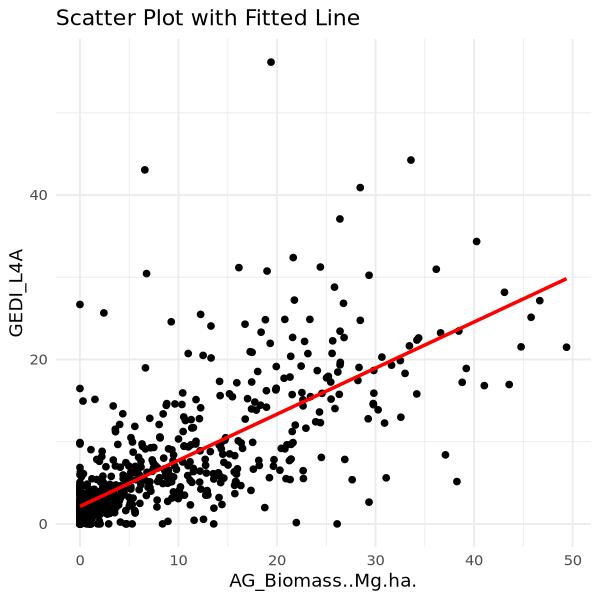

In [16]:
###############################################################################
# ##### CHECK WHAT DATA LOOKS LIKE BEFORE MODELING ############################
###############################################################################

options(repr.plot.width=5, repr.plot.height=5)
NFI = read.csv("/projects/my-private-bucket/Data/NFI_data/Sudan/DATA.csv")
plot(NFI$AG_Biomass..Mg.ha.,NFI$FNF)
plot(NFI$AG_Biomass..Mg.ha.,NFI$GEDI_L4A,xlim=c(0,70),ylim=c(0,70))

LM_model <- (lm(NFI$AG_Biomass..Mg.ha.~ NFI$GEDI_L4A))
summary(LM_model)
predictions <- predict(LM_model)
residuals <- NFI$AG_Biomass..Mg.ha. - predictions
rmse <- sqrt(mean(residuals^2))
print(paste("RMSE:", rmse))

ggplot(NFI, aes(x = AG_Biomass..Mg.ha., y = GEDI_L4A)) +
  geom_point() +  # Scatter points
  geom_smooth(method = "lm", se = FALSE, color = "red") +  # Fit line
  labs(title = "Scatter Plot with Fitted Line", x = "AG_Biomass..Mg.ha.", y = "GEDI_L4A") + theme_minimal()

formula = (AG_Biomass..Mg.ha.)~ (GEDI_L4A)
INLA_model <- inla(formula, data=NFI, family="gaussian",control.compute=list(config = T, dic = T, waic = T, cpo=TRUE)) #option cpo is a leave-one-out cross validation
summary(INLA_model)

#### Let's do a quick comparison, just to see how our outputs compare 
output <- cbind(summary(LM_model)$coef[,1:2],INLA_model$summary.fixed[,1:5]) # Looking great! 
colnames(output) <- c("lm():Mean","lm():SE","inla():Mean","inla():SD","inla():0.025quant","inla():0.5quant","inla():0.975quant")
output # Looking great! 

Reading layer `ne_10m_admin_0_countries' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Sudan_NE.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 168 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 21.80945 ymin: 8.681642 xmax: 38.60385 ymax: 22.22696
Geodetic CRS:  WGS 84


Warning message in knn2nb(knearneigh(coordinates, k = 2)):
“neighbour object has 5 sub-graphs”



	Moran I test under randomisation

data:  DATA$AG_Biomass..Mg.ha.  
weights: listw    

Moran I statistic standard deviate = 19.641, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.655948398      -0.001277139       0.001119740 



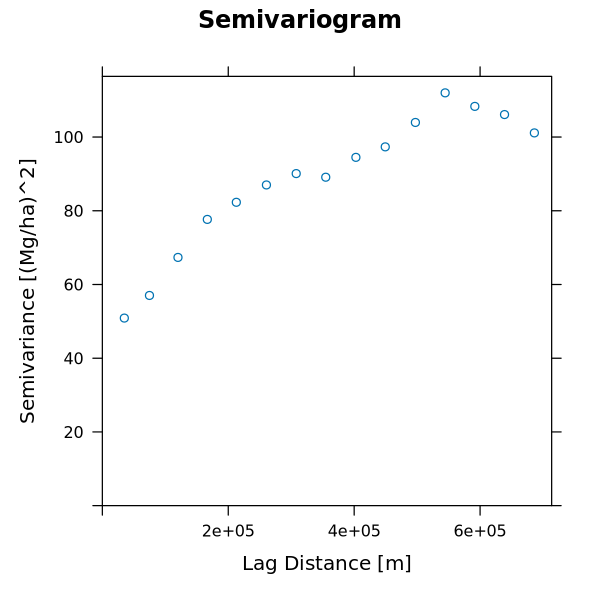

In [17]:
###############################################################################
####### ##############  DO MORAN'S I TEST ############## ######################
###############################################################################

Sudan <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Sudan_NE.gpkg")
Sudan <- Sudan %>% st_transform(crs=6933)
FNF <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Sudan_FNF_probability_2023_updated_6933.tif")
THRESHOLD_FOREST_PROBABILITY = 10

DATA = read.csv("/projects/my-private-bucket/Data/NFI_data/Sudan/DATA.csv")
DATA$gedi.agbd <- (DATA$GEDI_L4A)
DATA$HEIGHT.agb <- (DATA$HEIGHT)
DATA$FNF.prob <- (DATA$FNF)

coordinates <- cbind(DATA$X, DATA$Y)
neighbors <- knn2nb(knearneigh(coordinates, k = 2)) 
listw <- nb2listw(neighbors)
moran_result <- moran.test(DATA$AG_Biomass..Mg.ha., listw)
print(moran_result)

# A very high standard deviation like 19.641 suggests that the observed value is significantly different from the expected mean (which is usually 0).
# This p-value is extremely small, indicating strong statistical significance.

coordinates(DATA) <- ~X + Y
v <- variogram(AG_Biomass..Mg.ha. ~ 1, DATA)
plot(v, main = "Semivariogram", xlab = "Lag Distance [m]", ylab = "Semivariance [(Mg/ha)^2]")

Reading layer `ne_10m_admin_0_countries' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Sudan_NE.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 168 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 21.80945 ymin: 8.681642 xmax: 38.60385 ymax: 22.22696
Geodetic CRS:  WGS 84


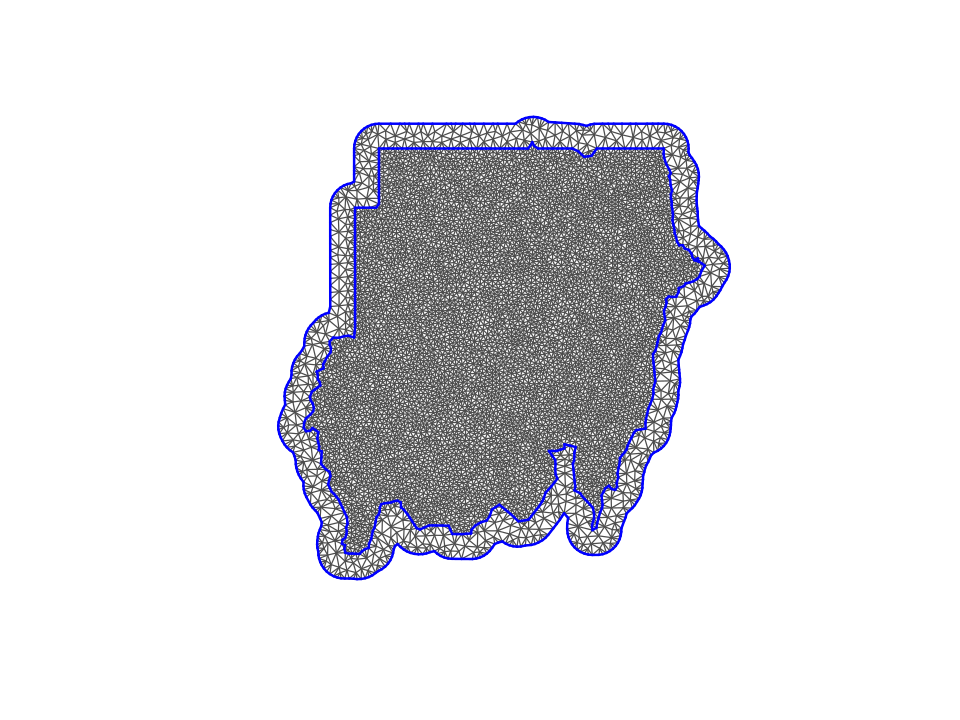

In [19]:
###################################################################
################ BEGIN MODELING - CREATE INLA MESH ################
###################################################################

options(repr.plot.width=8, repr.plot.height=6)
Sudan <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Sudan_NE.gpkg")
Sudan <- Sudan %>% st_transform(crs=6933)

DATA <- read.csv("/projects/my-private-bucket/Data/NFI_data/Sudan/DATA.csv")
DATA <- DATA[DATA$gedi.agbd > 0,]
DATA <- DATA[DATA$AG_Biomass..Mg.ha. > 0,]
factor <- (1/3)
DATA$AG_Biomass..Mg.ha. <- (DATA$AG_Biomass..Mg.ha.)^factor

loc.plot <- data.matrix(as.data.frame(cbind(DATA$X,DATA$Y)))
nfi.agbd <- DATA$AG_Biomass..Mg.ha. 
gedi.agbd <- DATA$gedi.agbd
FNF.prob <- DATA$FNF.prob

max.edge = 20*10^3
Sudan.buffer = st_buffer(Sudan, dist = max.edge*5) # We also make a 5 km buffer around Sudan to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(Sudan, "Spatial"), as(Sudan.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
k = mesh$n ### This is the resulting number of vertices
loc.plot <- data.matrix(loc.plot) #In case loc.plot is a df rather than matrix, use "loc.plot <- data.matrix(loc.plot)"
plot(mesh)

n.plot = nrow(loc.plot)
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) # make a new projector matrix with the new mesh and the same plot locations. 

Time used:
    Pre = 0.878, Running = 217, Post = 1.17, Total = 219 
Fixed effects:
           mean    sd 0.025quant 0.5quant 0.975quant  mode kld
intercept 0.835 0.256      0.334    0.835      1.336 0.835   0
L4A       0.032 0.005      0.022    0.032      0.043 0.032   0
FNF       0.012 0.003      0.006    0.012      0.017 0.012   0

Random effects:
  Name	  Model
    alpha.spat SPDE2 model
   beta.spat SPDE2 model
   eta.spat SPDE2 model

Model hyperparameters:
                                            mean       sd 0.025quant 0.5quant
Precision for the Gaussian observations 5.48e+00 3.70e-01   4.78e+00 5.47e+00
Range for alpha.spat                    8.17e+05 3.57e+05   3.67e+05 7.39e+05
Stdev for alpha.spat                    4.67e-01 1.23e-01   2.83e-01 4.48e-01
Range for beta.spat                     2.99e+05 4.56e+05   2.92e+04 1.68e+05
Stdev for beta.spat                     1.20e-02 5.00e-03   5.00e-03 1.10e-02
Range for eta.spat                      4.78e+05 3.69e+05   1.06

[1] 0.9436393

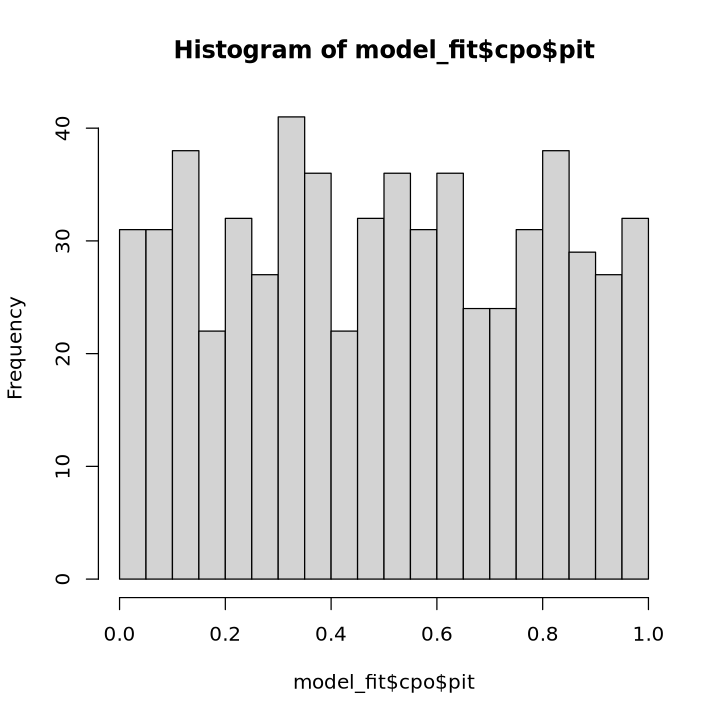

In [25]:
###############################################################
################ SET PRIORS AND RUN MODEL #####################
###############################################################

# Priors for the varying intercept alpha_tilde
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30*10^3, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the SD is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient beta_tilde
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30*10^3, 0.01), # Same interpretations as above here
                                prior.sigma = c(1, 0.5)) # This says the probability that the SD is GREATER than 1 is 0.5


# Priors for the varying coefficient eta_tilde
spde.eta = inla.spde2.pcmatern(mesh, 
                               prior.range = c(30*10^3, 0.01), # Same interpretations as above here
                               prior.sigma = c(1, 0.5)) # This says the probability that the SD is GREATER than 1 is 0.5


### Construct our formula #####
formula = agbd ~
  -1 + # removes the automatic intercept so you can include your named intercept
  intercept + # alpha
  L4A +   #beta
  FNF +   #eta
  f(alpha.spat, model = spde.alpha) + #alpha-tilde
  f(beta.spat, model = spde.beta) + #beta-tilde
  f(eta.spat, model = spde.eta) #eta-tilde 

## Arrange our data so we can supply it to INLA to input in the formula above #####
stack = inla.stack(data = list(agbd = nfi.agbd),
                   A = list(1, # tell INLA we expect an intercept, and the projection matrix is just "1"
                            1, # tell INLA we expect a GEDI value, and the projection matrix for its parameter is just "1"
                            1, # tell INLA we expect a FNF value, and the projection matrix for its parameter is just "1"
                            A.plot, # tell INLA we have a mesh projected onto the plot locations for alpha-tilde 
                            Diagonal(x = gedi.agbd)%*%A.plot, # tell INLA to multiply our mesh with GEDI values for Beta-tilde
                            Diagonal(x = FNF.prob)%*%A.plot), # tell INLA to multiply our mesh with FNF values for eta-tilde
                   effects = list(
                     intercept = rep(1, n.plot), # The intercept just given an index equal to 1
                     L4A = gedi.agbd, # Supply INLA with the GEDI values
                     FNF = FNF.prob, # Supply INLA with the FNF values
                     alpha.spat = 1:k, # The random effects just need to given unique indices at each mesh node.
                     beta.spat = 1:k, # The random effects just need to given unique indices at each mesh node.
                     eta.spat = 1:k # The random effects just need to given unique indices at each mesh node.
                   ))

model_fit = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = T, dic = T, waic = T, cpo = T),
                 control.inla = list(int.strategy = "eb"), # EB just fixes the hyperparameters at their maximum posterior (like maximum likelihood, but accounting for priors) values. The other methods manually integrate across the range of possible values.
                 verbose = TRUE)

summary(model_fit)
save(model_fit, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
hist(model_fit$cpo$pit, breaks = 20) 

PITs <- model_fit$cpo$pit
length(PITs[PITs >= 0.025 & PITs <= 0.975])/length(PITs)

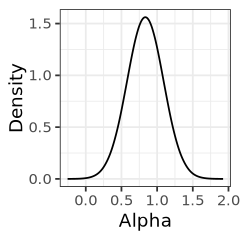

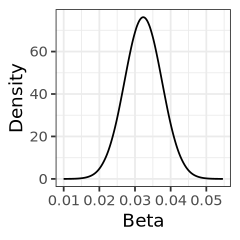

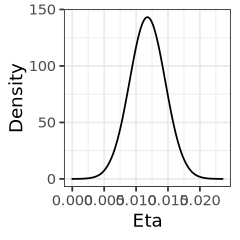

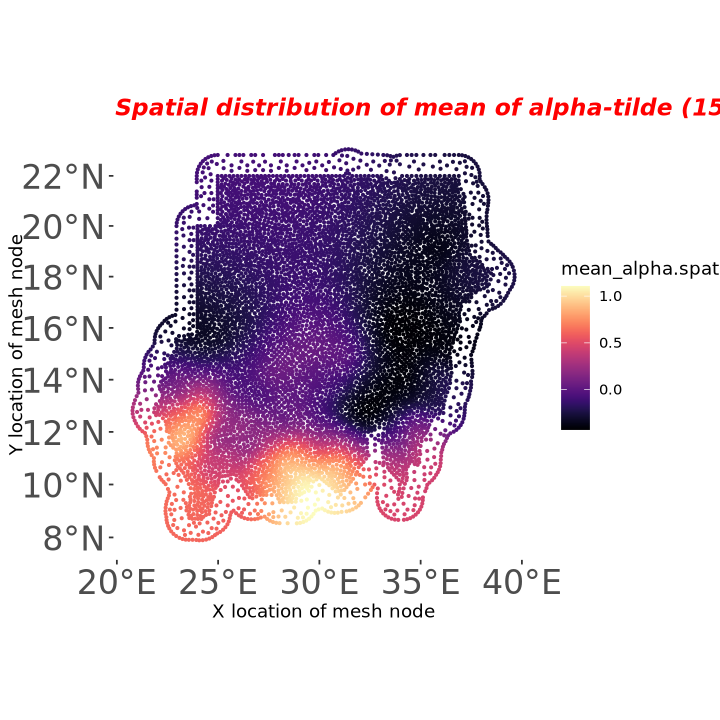

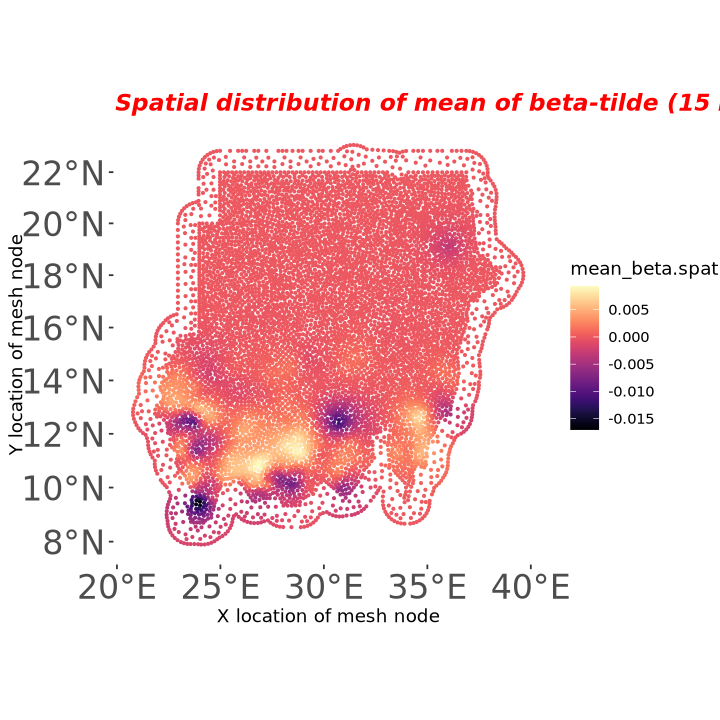

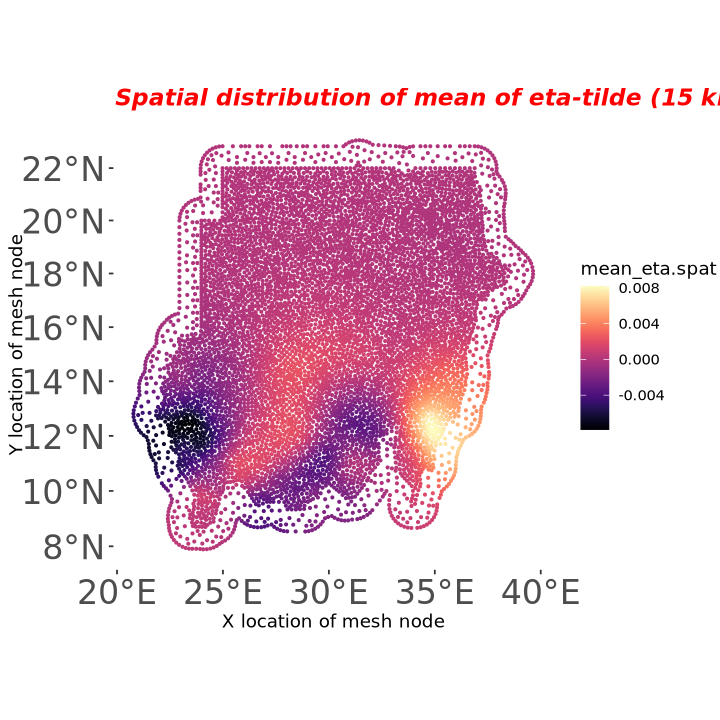

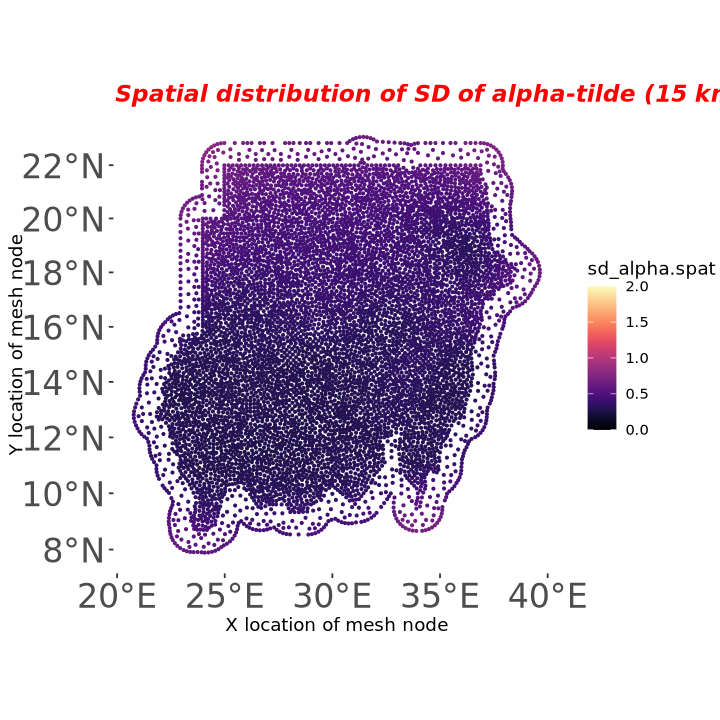

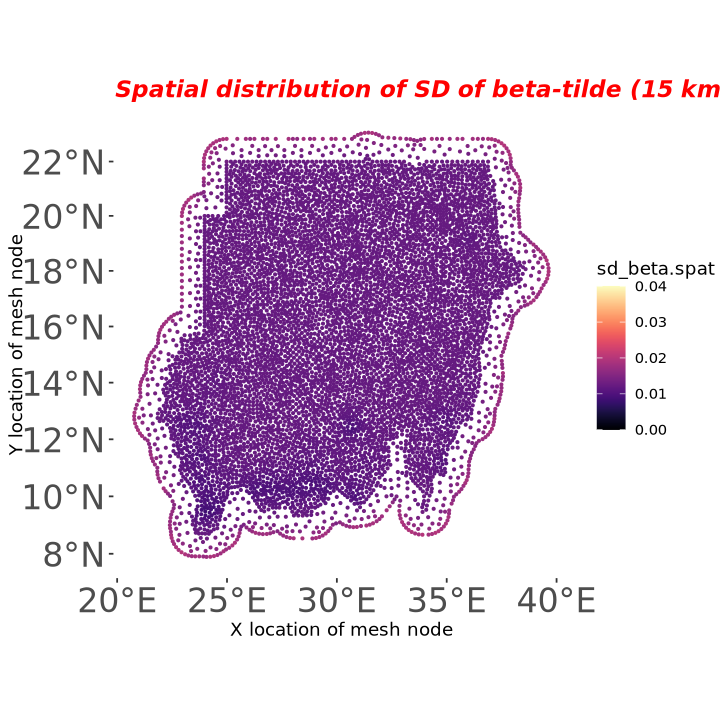

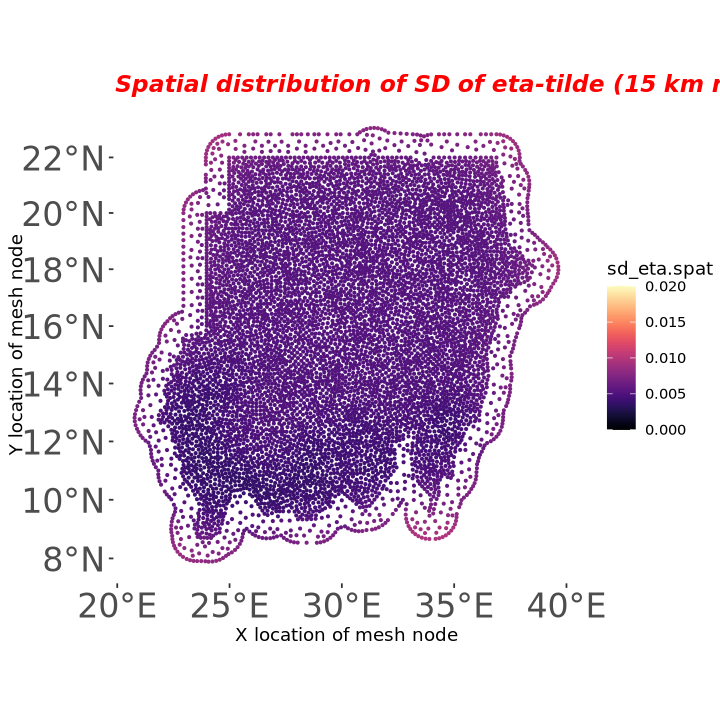

In [33]:
#############################################################################################
##################### LETS VISUALIZE THE MODEL PARAMETERS ###################################
#############################################################################################

options(repr.plot.width=2, repr.plot.height=2)
load("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")

# When inla() is executed, we obtain an object of class "inla" that contains the information of the fitted model 
# including summaries and posterior marginal densities of the fixed effects, 
# the random effects, and the hyperparameters (and many more things, but we explore only these for now). 

# The fixed effects are straighforward to understand. Below, we see the posterior elements of the intercept alpha, and parameters beta and eta. 
alpha <- model_fit$marginals.fixed[[1]]
beta <- model_fit$marginals.fixed[[2]]
eta <- model_fit$marginals.fixed[[3]]
ggplot(data.frame(inla.smarginal(alpha)), aes(x, y)) + geom_line() + theme_bw() + xlab("Alpha") + ylab("Density")
ggplot(data.frame(inla.smarginal(beta)), aes(x, y)) + geom_line() + theme_bw() + xlab("Beta") + ylab("Density")
ggplot(data.frame(inla.smarginal(eta)), aes(x, y)) + geom_line() + theme_bw() + xlab("Eta") + ylab("Density")

# The random effects, in our case, are also easy to understand from the model outputs. The posterior distributions of the range and SD of alpha.spat, 
# beta.spat and eta.spat show us how these random effects vary across Sudan.

options(repr.plot.width=6, repr.plot.height=6)

mean_alpha.spat <- model_fit$summary.random[[1]]$mean # mean values of alpha.spat at each mesh vertex
sd_alpha.spat <- model_fit$summary.random[[1]]$sd # standard deviation of alpha.spat at each mesh node 

mean_beta.spat <- model_fit$summary.random[[2]]$mean # mean values of alpha.spat at each mesh vertex
sd_beta.spat <- model_fit$summary.random[[2]]$sd # standard deviation of alpha.spat at each mesh node 

mean_eta.spat <- model_fit$summary.random[[3]]$mean # mean values of alpha.spat at each mesh vertex
sd_eta.spat <- model_fit$summary.random[[3]]$sd # standard deviation of alpha.spat at each mesh node 

ggplot() + coord_sf(crs = 6933) + 
  geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = mean_alpha.spat),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
  scale_color_viridis(option="magma") + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of mean of alpha-tilde (15 km mesh)") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),axis.text=element_text(size=20),axis.title=element_text())
ggplot() + coord_sf(crs = 6933) + 
  geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = mean_beta.spat),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
  scale_color_viridis(option="magma") + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of mean of beta-tilde (15 km mesh)") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),axis.text=element_text(size=20),axis.title=element_text())
ggplot() + coord_sf(crs = 6933) + 
  geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = mean_eta.spat),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
  scale_color_viridis(option="magma") + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of mean of eta-tilde (15 km mesh)") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),axis.text=element_text(size=20),axis.title=element_text())
ggplot() + coord_sf(crs = 6933) + 
  geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = sd_alpha.spat),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
  scale_color_viridis(option="magma",limits=c(0,2)) + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of SD of alpha-tilde (15 km mesh)") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),axis.text=element_text(size=20),axis.title=element_text())
ggplot() + coord_sf(crs = 6933) + 
  geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = sd_beta.spat),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
  scale_color_viridis(option="magma",limits=c(0,0.04)) + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of SD of beta-tilde (15 km mesh)") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),axis.text=element_text(size=20),axis.title=element_text())
ggplot() + coord_sf(crs = 6933) + 
  geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = sd_eta.spat),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
  scale_color_viridis(option="magma",limits=c(0,0.02)) + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of SD of eta-tilde (15 km mesh)") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),axis.text=element_text(size=20),axis.title=element_text())
options(repr.plot.width=4, repr.plot.height=4)

# DIC, WAIC and the CPO and PIT are standard Bayesian model diagnostics, which tell us how our model is performing. 

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


[1] 0.7243931

[1] 5.304047

[1] 0.05492628

[1] 0.9613527

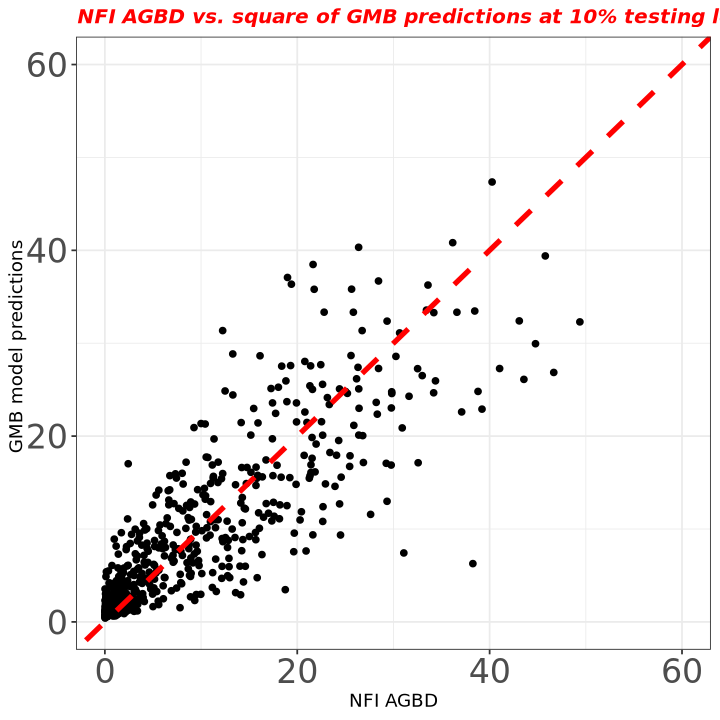

In [34]:
###############################################################
######## SCATTER PLOT OF PREDICTIONS VS. NFI-ESTIMATES ########
###############################################################
load("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
samples = inla.posterior.sample(n = 1000, result = model_fit) # Draw posterior samples from our model fit 

# Our model function
pred_fun = function(...){
  drop(intercept + 
         gedi.agbd*L4A +
         FNF.prob*FNF +
         A.plot%*%alpha.spat[1:k] +   
         Diagonal(x = gedi.agbd)%*%A.plot%*%beta.spat[1:k] + 
         Diagonal(x = FNF.prob)%*%A.plot%*%eta.spat[1:k]) +
    rnorm(nrow(A.plot), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^(1/factor),na.rm=TRUE)
pred.sd = apply(pred.samples^(1/factor), 1, sd)
options(repr.plot.width=5, repr.plot.height=5)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=nfi.agbd^(1/factor), PRED.SD=pred.sd, RES=nfi.agbd^(1/factor)-pred.mu))
options(repr.plot.width=6, repr.plot.height=6)
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,60) + ylim(0,60) + xlab("NFI AGBD") + ylab("GMB model predictions ") + ggtitle("NFI AGBD vs. square of GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),axis.text=element_text(size=20))

####################################################################
######################## HEURISTICS: R2 AND RMSE ###################
####################################################################

R2_backtrans = 1 - (sum((pred.mu - nfi.agbd^(1/factor))^2,na.rm=TRUE)/sum((nfi.agbd^(1/factor) - mean(nfi.agbd^(1/factor),na.rm=TRUE))^2,na.rm=TRUE))
R2_backtrans
RMSE = sqrt(mean((pred.mu - nfi.agbd^(1/factor))^2,na.rm=TRUE))
RMSE
BIAS = mean(pred.mu,na.rm=TRUE) - mean(nfi.agbd^(1/factor),na.rm=TRUE)
BIAS # Mg/ha

###########################################################################
############## RATE OF OVERLAP OF CREDIBILITY INTERVALS ###################
###########################################################################

Q25 <- apply(pred.samples^(1/factor), 1, quantile, probs = c(0.025), na.rm=TRUE)
Q975 <- apply(pred.samples^(1/factor), 1, quantile, probs = c(0.975), na.rm=TRUE)
sum((nfi.agbd^(1/factor) >= Q25) & (nfi.agbd^(1/factor) <= Q975), na.rm=TRUE)/length(nfi.agbd^(1/factor))